# Outline for getting onnx v3 working

In [1]:
!wget https://github.com/onnx/models/raw/master/vision/object_detection_segmentation/yolov3/model/yolov3-10.onnx

--2021-06-10 22:17:08--  https://github.com/onnx/models/raw/master/vision/object_detection_segmentation/yolov3/model/yolov3-10.onnx
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/onnx/models/master/vision/object_detection_segmentation/yolov3/model/yolov3-10.onnx [following]
--2021-06-10 22:17:08--  https://media.githubusercontent.com/media/onnx/models/master/vision/object_detection_segmentation/yolov3/model/yolov3-10.onnx
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247908721 (236M) [application/octet-stream]
Saving to: ‘yolov3-10.onnx’

yolov3-10.onnx      100%[=============

In [2]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2021-06-10 22:17:29--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.238.107
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.238.107|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  51.0MB/s    in 17s     

2021-06-10 22:17:46 (45.7 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
!unzip val2017.zip

In [4]:
!pip install onnxruntime Pillow

     |████████████████████████████████| 4.5MB 4.0MB/s 


In [5]:
import onnxruntime
from PIL import Image
session = onnxruntime.InferenceSession('./yolov3-10.onnx')

In [6]:
print(session.get_inputs()[0].name)
print(session.get_inputs()[1].name)

input_1
image_shape


In [7]:
import glob
img_paths = glob.glob("./val2017/*.jpg")

In [14]:
import numpy as np
from PIL import Image

# this function is from yolo3.utils.letterbox_image
def letterbox_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def preprocess(img):
    model_image_size = (416, 416)
    boxed_image = letterbox_image(img, tuple(reversed(model_image_size)))
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.transpose(image_data, [2, 0, 1])
    image_data = np.expand_dims(image_data, 0)
    return image_data

image = Image.open(img_paths[0])
# input
image_data = preprocess(image)
image_size = np.array([image.size[1], image.size[0]], dtype=np.float32).reshape(1, 2)

In [11]:
img_paths[0]

'./val2017/000000456015.jpg'

Can't seem to display images via Pillow within Colab. Gonna use matplotlib to see.

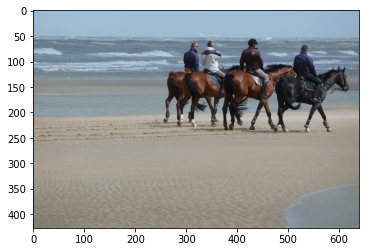

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(img_paths[0])
imgplot = plt.imshow(img)
plt.show()

In [15]:
import cv2
import numpy as np
input_name = session.get_inputs()[0].name
size = session.get_inputs()[1].name

img_dims = 416
img = cv2.imread(img_paths[0])
img = cv2.resize(img, (img_dims, img_dims), interpolation=cv2.INTER_LINEAR)

all_boxes, all_scores, indices = session.run(None, {input_name: image_data, size:image_size})

In [16]:
all_boxes.shape

(1, 10647, 4)

In [17]:
all_scores.shape

(1, 80, 10647)

In [18]:
indices.shape

(7, 3)

# POST PROCESSING

In [19]:
out_boxes, out_scores, out_classes = [], [], []
for idx_ in indices:
    out_classes.append(idx_[1])
    out_scores.append(all_scores[tuple(idx_)])
    idx_1 = (idx_[0], idx_[2])
    out_boxes.append(all_boxes[idx_1])

In [20]:
out_boxes#, out_scores, out_classes

[array([ 65.52015, 514.0927 , 179.52776, 575.2903 ], dtype=float32),
 array([ 56.736877, 406.9955  , 163.72438 , 460.90558 ], dtype=float32),
 array([ 58.575108, 330.82858 , 155.90001 , 380.24854 ], dtype=float32),
 array([ 62.373802, 297.51898 , 139.58727 , 331.36224 ], dtype=float32),
 array([106.634155, 469.46008 , 238.32925 , 626.61615 ], dtype=float32),
 array([ 96.18244, 367.50214, 240.76451, 503.6474 ], dtype=float32),
 array([ 98.779755, 261.15796 , 229.21136 , 401.75916 ], dtype=float32)]

In [21]:
out_scores

[0.9967557,
 0.9805892,
 0.9762702,
 0.82940924,
 0.99792546,
 0.99193937,
 0.9438846]

In [22]:
out_classes

[0, 0, 0, 0, 17, 17, 17]

Coco classes and the output are 1 index off (because of 0-indexing)...
But the 0's (Actually 1 in Coco) are people and 17's (Actually 18 in Coco) are horses... so I'd say it's working pretty well. Scores are high too.

Next step is formatting each line